# Repositorio GCM-TFG
## Problemas de optimización en el modelado de materia oscura galáctica

En este repositorio se implementan las funciones necesarias para tratar el problema de modelado de componentes galácticas, en particular el de la componente de materia oscura.  
A continuación se detallan los ficheros y sus respectivas funciones, así como los tipos y estructuras de datos que usan.
### `data.py`
Contiene la lista `galaxlist` de galaxias a explorar. Para cada galaxia se abre y lee su respectivo archivo `.arff`, en el que cada fila corresponde a una partícula que se ha observado que gira en torno a la galaxia. Para cada una de estas partículas se tienen los siguientes datos:
* Radio de giro en torno a la galaxia
* Velocidad rotacional de la partícula
* Errores
* Velocidad debida a la materia bariónica bariónica

A partir de estos datos construye el diccionario `galaxies` donde se asocia cada galaxia con los datos que se tienen de ella:
* `R`: Vector de radios de giro de las diferentes partículas observadas
* `vrot`: Vector de velocidades rotacionales
* `errs`: Vector de errores
* `vbary`: Vector de velocidades debidas a la materia bariónica

A continuación se muestra un ejemplo de lectura y recogida de datos de una de las 23 galaxias estudiadas.

In [48]:
from scipy.io import arff
import numpy as np

galaxlist = ["DDO43"]
galaxies = {}
for i in galaxlist:
    fp = open("galaxies/"+i+".arff")
    dt, metadt = arff.loadarff(fp)
    data = []
    for d in dt.tolist():
        data.append(np.asarray(d))
    data = np.asarray(data)
    galaxies[i] = {
        "R": data[:, 0] * 1000,
        "vrot": abs(data[:, 1]),
        "errs": data[:, 3],
        "vbary": np.sqrt(data[:, 4] ** 2 + data[:, 5] ** 2)
    }
    fp.close()

Vector de radios de la galaxia DDO43:

In [49]:
print(galaxies["DDO43"]["R"])

[ 470.       930.00001 1400.      1860.      2329.9999  2790.
 3260.      3720.      4190.0001 ]


Vector de velocidades rotacionales de la galaxia DDO43:

In [50]:
print(galaxies["DDO43"]["vrot"])

[ 7.9899998 18.290001  24.59      28.82      32.959999  33.830002
 36.07      36.490002  31.09     ]


Vector de errores de la galaxia DDO43:

In [52]:
print(galaxies["DDO43"]["errs"])

[2.8900001 2.3900001 2.25      2.0699999 2.27      2.51      2.6700001
 2.8199999 2.8199999]


Vector de velocidades debidas a la materia bariónica de la galaxia DDO43:

In [53]:
print(galaxies["DDO43"]["vbary"])

[ 8.50096437 12.10877402 16.20661634 21.7422264  24.2805876  24.91602689
 25.43348398 26.03271224 26.90978314]


En `data.py` también se declaran las constantes $\nu$ (número de parámetros libres) y $CteDim$ (constante de adimensionalización).
* Puesto que sólo trabajaremos con los perfiles ISO, BUR y NFW, $\nu = 2$.
* $CteDim = \frac{10000}{4.51697\times3.0856776^ 2}$.  

A continuación creamos el diccionario `galaxdata`, donde almacenaremos los datos que más usaremos, en este caso de la galaxia DDO43.

In [41]:
import commonFunctions as cf
import data as dt

galaxdata = {
    "radii": np.array([]),
    "vrot": np.array([]),
    "vbary": np.array([]),
    "weights": np.array([]),
    "CteDim": dt.CteDim,
    "totalnullvbary": False,
    "somenullvbary": False,
    "vones": np.array([]),
    "vv": np.array([]),
    "vvbary": np.array([]),
    "profile": '',
    "graphic": False
}

for i in galaxlist:
    radii = galaxies[i]["R"]
    galaxdata["radii"] = radii
    vrot = galaxies[i]["vrot"]
    galaxdata["vrot"] = vrot
    vbary = galaxies[i]["vbary"]
    galaxdata["vbary"] = vbary
    n = len(radii)
    vones = np.ones(n)
    galaxdata["vones"] = vones
    weights = 1 / ((n - dt.nu) * galaxies[i]["errs"] ** 2)
    galaxdata["weights"] = weights
    totalnullvbary = np.sum(vbary) == 0
    galaxdata["totalnullvbary"] = totalnullvbary
    somenullvbary = round(np.prod(vbary)) == 0
    galaxdata["somenullvbary"] = somenullvbary
    vv = cf.vv(galaxdata)
    galaxdata["vv"] = vv
    vvbary = cf.vvbary(galaxdata)
    galaxdata["vvbary"] = vvbary
    # galaxdata["graphic"] = True

### `commonFunctions.py`
Aquí se definen algunas funciones comunes a todas las galaxias y para cualquiera de los perfiles ISO, BUR y NFW.  
* `WeighProd(x, y, sigmas)`: Dados los arrays `x` e `y`, y los pesos `sigmas` devuelve el producto escalar pesado definido en (15).  
* `ginf(x, model)`: Dados un array `x` y un perfil de densidad `model`, devuelve el valor de g cuando s tiende a infinito, definida en la Tabla 2.  
* `eqVLimInf(t, ginf, galaxdata)`: Dados el parámetro `t`, el valor de g definida en la Tabla 2 cuando s tiende a infinito y el diccionario `galaxdata` de datos de la galaxia, devuelve la ecuación definida en (33).  
* `g0(x, model)`: Dado un array `x` y un perfil de densidad `model`, devuelve el valor de g cuando s tiende a cero, definida en la Tabla 2.  
* `eqVLim0(t, g0, galaxdata)`: Dados el parámetro `t`, el valor de g definida en la Tabla 2 cuando s tiende a cero y el diccionario `galaxdata` de datos de la galaxia, devuelve la ecuación definida en (35).  
* `v(r, s, model)`: Dado un array de radios `r`, un array de inversos de parámetros de escalas `s` y un perfil de densidad de materia oscura `model`, devuelve el valor de la ecuación definida en (18) para estos parámetros.  
* `chiquad(rho, s, galaxdata)`: Dados un array de parámetro de densidad central `rho`, un array de de inversos de parámetros de escala `s` y un diccionario de datos de una galaxia `galaxdata`, devuelve el valor de la ecuación definida en (16) para estos parámetros.  
* `rho(s, galaxdata)`: Dados un array de inversos de parámetros de escala `s` y un diccionario de datos de una galaxia `galaxdata`, devuelve el valor de rho estudiado en la Proposición 1.  
* `alphaMV(s, galaxdata)`: Dados un array de inversos de parámetros de escala `s` y un diccionario de datos de una galaxia `galaxdata`, devuelve el valor de la ecuación (24) para estos parámetros.  
* `vv(galaxdata)`: Dado un diccionario de datos de una galaxia `galaxdata`, devuelve el producto escalar pesado de la velocidad rotacional.  
* `vvbary(galaxdata)`: Dado un diccionario de datos de una galaxia `galaxdata`, devuelve el el producto escalar pesado de la velocidad debida a la materia bariónica.  
* `phi(s, galaxdata)`: Dados un array de inversos de parámetros de escala `s` y un diccionario de datos de una galaxia `galaxdata`, devuelve el valor de la función varphi y el valor de la función rho para estos parámetros.

### `calLimits.py`
Aquí se define la función que calcula los límites de varphi en cero y en infinito, usando el Lema 1.  
* `calLimits(galaxdata)`: Dado un diccionario de datos de una galaxia `galaxdata`, devuelve un array con los valores de los límites de varphi en cero y en infinito.  
Calculamos los límites para la galaxia DDO43 con el perfil ISO.

In [60]:
from calLimits import *

galaxdata["profile"] = "ISO"
varphiLim0, varphiLimInf = calLimits(galaxdata)

El límite de varphi cuando s tiende a 0 para la galaxia DDO43 con el perfil ISO es

In [61]:
print(varphiLim0)

3.7583267955556607


El límite de varphi cuando s tiende a infinito para la galaxia DDO43 con el perfil ISO es

In [62]:
print(varphiLimInf)

4.058958699663322


Calculamos los límites para la galaxia DDO43 con el perfil BUR.

In [63]:
galaxdata["profile"] = "BUR"
varphiLim0, varphiLimInf = calLimits(galaxdata)

El límite de varphi cuando s tiende a 0 para la galaxia DDO43 con el perfil BUR es

In [64]:
print(varphiLim0)

3.7583267955556607


El límite de varphi cuando s tiende a infinito para la galaxia DDO43 con el perfil BUR es

In [65]:
print(varphiLimInf)

10.866553658143346


Calculamos los límites para la galaxia DDO43 con el perfil NFW.

In [66]:
galaxdata["profile"] = "NFW"
varphiLim0, varphiLimInf = calLimits(galaxdata)

El límite de varphi cuando s tiende a 0 para la galaxia DDO43 con el perfil NFW es

In [67]:
print(varphiLim0)

1.448860004687731


In [68]:
print(varphiLimInf)

10.866553658143346


### `intervalMinim.py`
Aquí se definen las distintas funciones que forman el algoritmo de reducción del intervalo de búsqueda. Se especifica una tolerancia `tol`$=10^{-2}$ y se fija la semilla del random a 1.  
* `inftestElementwise(eval)`: Dado un array de puntos vecinos al candidato a extremo inferior del intervalo `eval`, devuelve dos booleanos. El primero indica si los puntos vecinos de la derecha cumplen la ecuación (40) y el segundo indica si la cumplen los vecinos de la izquierda.  
* `suptestElementwise(eval)`: Dado un array de puntos vecinos al candidato a extremo superior del intervalo `eval`, devuelve dos booleanos. El primero indica si los puntos vecinos de la izquierda cumplen la ecuación (39) y el segundo indica si la cumplen los vecinos de la derecha.  
* `inftestElementsum(eval)`: Dado un array de puntos vecinos al candidato a extremo inferior del intervalo `eval`, devuelve dos booleanos. El primero indica si la suma de los puntos vecinos de la derecha cumplen la ecuación (40) y el segundo indica si la cumple la suma de los vecinos de la izquierda.
* `suptestElementsum(eval)`: Dado un array de puntos vecinos al candidato a extremo superior del intervalo `eval`, devuelve dos booleanos. El primero indica si la suma de los puntos vecinos de la izquierda cumplen la ecuación (39) y el segundo indica si la cumple la suma de los vecinos de la derecha.  
* `infConditions(test1, test2, intervalinf, stop, i)`: Dados un booleano `test1` indicando si los puntos de la derecha (o su suma) cumplen (40), un booleano `test2` indicando si los puntos de la izquierda (o su suma) cumplen (40), un candidato a extremo inferior del intervalo `intervalinf`, un parámetro que controla la condición de parada del algoritmo `stop` y un parámetro `i` que almacena el anterior candidato a extremo inferior en caso de que estemos acercándonos a estar en condición de parada, la función decide si el candidato cumple la condición óptima y en qué dirección moverse.  

Supongamos que estamos evaluando la situación de un candidato `intervalinf = 1.5` a extremo inferior. Sus vecinos de la derecha no cumplen (40), y sus vecinos de la izquierda tampoco, es decir, `test1 = False` y `test2 = False`. No estamos en condición de parada, `stop = False`, y el candidato anterior a extremo inferior `i` es cualquiera, supongamos `i=2.0`.

In [69]:
from intervalMinim import *

test1 = False
test2 = False
stop = False
i = 2.0
intervalinf = 1.5

new_intervalinf, direction, stop, i = infConditions(test1, test2, intervalinf, stop, i)

¿En qué dirección debemos movernos?

In [70]:
print(direction)

-1


El nuevo candidato a extremo inferior es

In [71]:
print(new_intervalinf)

1.2017842073567433


¿Estamos en condición de parada?

In [72]:
print(stop)

False


El candidato anterior no ha cambiado, el valor de i sigue siendo

In [73]:
print(i)

2.0


Supongamos ahora que estamos evaluando la situación de un candidato `intervalinf = 1.2` a extremo inferior que no está en condición de parada, `stop = False`. Sus vecinos de la izquierda cumplen (40), pero sus vecinos de la derecha no, es decir, `test2 = True` y `test1 = False`. El candidato anterior a extremo inferior `i`es cualquiera, supongamos `i=1.25`.

In [74]:
test1 = False
test2 = True
stop = False
i = 1.28
intervalinf = 1.2

new_intervalinf, direction, stop, i = infConditions(test1, test2, intervalinf, stop, i)

¿En qué dirección debemos movernos?

In [75]:
print(direction)

-1


Nos movemos para comprobar en la siguiente iteración que los puntos en esta dirección siguen cumpliendo (40). En la siguiente iteración estudiaremos el punto

In [76]:
print(new_intervalinf)

0.6371014232668135


¿Estamos en condición de parada?

In [77]:
print(stop)

True


El candidato anterior ha cambiado, ahora el valor de i es

In [78]:
print(i)

1.2


Ahora, para alcanzar por completo la condicón óptima, los valores a la izquierda del candidato `i =  1.2` deberían cumplir (40). Supongamos que sí: `test1 = True` y `test2 = True`. 

In [45]:
test1 = True
test2 = True

intervalinf, direction, stop, i = infConditions(test1, test2, new_intervalinf, stop, i)

Ahora la dirección es

In [46]:
print(direction)

0


Esta dirección indica que hemos alcanzaco la condición de parada. Recuperamos de i el que era nuestro candidato. Ahora intervalinf tiene el valor

In [47]:
print(intervalinf)

1.2


* `supConditions(test1, test2, intervalsup, stop, i)`: Dados un booleano `test1` indicando si los puntos de la izquierda (o su suma) cumplen (39), un booleano `test2` indicando si los puntos de la derecha (o su suma) cumplen (39), un candidato a extremo superior del intervalo `intervalsup`, un parámetro que controla la condición de parada del algoritmo `stop` y un parámetro `i` que almacena el anterior candidato a extremo superior, la función decide si el candidato cumple la condición óptima y en qué dirección moverse.  
* `jumpCondition(twoclosevar, varLimdistance, interval, direction, k)`: Dados un booleano `twoclosevar` indicando si los dos últimos candidatos están "cerca", un valor `varLimdistance` indicando a qué distancia está el candidato del valor del límite, un candidato `interval`, una dirección (-1, 0 o 1) `direction` y un contador de la condición de salto `k`, la función devuelve si ha habido salto y, en caso de que sí, cuál es el nuevo candidato.  
* `intervalMin(varphiLim0, varphiLimInf, galaxdata)`: Dados el valor del límite de varphi en cero `varphiLim0`, el valor del límite de varphi en infinito `varphiLimInf` y un diccionario de datos de una galaxia `galaxdata`, la función realiza la reducción del intervalo de búsqueda. Primero busca el extremo inferior que cumple alguna condición satisfactoria y luego el extremo superior, análogamente. Finalmente devuelve los valores propuestos como extremos, el valor mínimo de varphi encontrado en la búsqueda del extremo inferior y el valor mínimo de varphi encontrado en la búsqueda del extremo superior. También puede devolver datos para la elaboración de gráficas.  

A continuación hacemos la minimización del intervalo de búsqueda para la galaxia DDO43 con el perfil ISO.

In [25]:
galaxdata["profile"] = "ISO"
varphiLim0, varphiLimInf = calLimits(galaxdata)

interval, intinfmin, intsupmin = intervalMin(varphiLim0, varphiLimInf, galaxdata)
intervalinf = interval[0]
intervalsup = interval[1]

Así, el extremo inferior del intervalo de búsqueda tras su exploración es

In [26]:
print(intervalinf)

2.700954727421944e-05


El extremo superior del intervalo de búsqueda tras su exploración es

In [27]:
print(intervalsup)

0.23865017533131844


El valor mínimo de varphi encontrado en la exploración del extremo inferior es

In [28]:
print(intinfmin[1])

0.8561628387327573


para el valor de s

In [29]:
print(intinfmin[0])

0.001


El valor mínimo de varphi encontrado en la exploración del extremo superior es

In [30]:
print(intsupmin[1])

3.9965984367814826


para el valor de s

In [31]:
print(intsupmin[0])

0.1505780808867812


A continuación se muestra la exploración del intervalo de búsqueda para su reducción para la galaxia DDO43 con perfil ISO. Los puntos rojos representan los puntos explorados y la línea negra el intervalo deducido en el algoritmo.

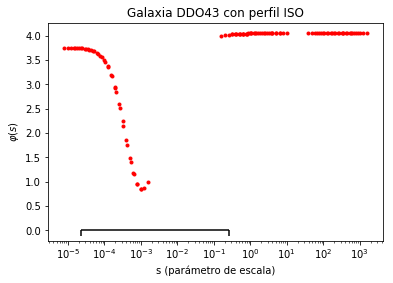

In [13]:
import matplotlib.pyplot as plt

galaxdata["graphic"] = True
res = intervalMin(varphiLim0, varphiLimInf, galaxdata)
intervalinf = res[0][0]
intervalsup = res[0][1]
Xi = res[1]
Yi = res[2]
intinfmin = res[3]
intsupmin = res[4]
plt.semilogx()
plt.title("Galaxia DDO43 con perfil ISO")
plt.xlabel("s (parámetro de escala)")
plt.ylabel(r"$\varphi(s)$")
plt.scatter(intervalinf, 0, c='black', marker=3)
plt.scatter(intervalsup, 0, c='black', marker=3)
plt.hlines(0, intervalinf, intervalsup)
plt.scatter(Xi, Yi, c='r', marker='.')
plt.show()

### `varphiMinim.py`
Aquí se definen las distintas funciones que forman el algoritmo de minimización de la función varphi.
* `getIMD(intizq, intder, galaxdata)`: Dados el extremo inferior del intervalo `intizq`, el extremo superior del intervalo `intder`y un diccionario de datos de una galaxia `galaxdata`, la función devuelve el valor medio `m`y su evaluación en varphi, así como un punto aleatorio a la derecha y otro a la izquierda, con sus respectivas evaluaciones en varphi.
* `reductionInterval(varphiLim0, varphiLimInf, intinfmin, intsupmin, intervalinf, intervalsup)`: Realiza la mejora propuesta en la memoria para el algoritmo de minimización de varphi. Dados el límite de varphi en 0 `varphiLim0`, el límite de varphi en infinito `varphiLimInf`, el punto mínimo encontrado en la exploración del intervalo inferior `intinfmin`, el punto mínimo encontrado en la exploración del intervalo superior `intsupmin`, el extremo inferior del intervalo calculado en intervalMinim.py `intervalinf` y el extremo superior del intervalo calculado en intervalMinim.py `intervalsup`, la función devuelve el intervalo de búsqueda nuevamente reducido (en caso de que haya sido posible reducirlo).  
* `varphiMin(varphiLim0, varphiLimInf, intinfmin, intsupmin, intervalinf, intervalsup, galaxdata)`: Dados el límite de varphi cuando s tiende a 0 `varphiLim0`, el límite de varphi cuando s tiende a infinito `varphiLimInf`, el punto mínimo encontrado en la exploración del intervalo inferior `intinfmin`, el punto mínimo encontrado en la exploración del intervalo superior `intsupmin`, el extremo inferior del intervalo calculado en intervalMinim.py `intervalinf`, el extremo superior del intervalo calculado en intervalMinim.py `intervalsup` y el diccionario de datos de una galaxia `galaxdata`, la función realiza la exploración de varphi y devuelve el mínimo valor encontrado.  

A continuación realizamos la minimización de varphi para la galaxia DDO43 con el perfil ISO.

In [18]:
from varphiMinim import *

res = varphiMin(varphiLim0, varphiLimInf, intinfmin, intsupmin, intervalinf, intervalsup, galaxdata)
minvarphi = res[0]
minrho = res[1]
minvarphiX = res[2]
Xj = res[3]
Yj = res[4]
forkpoints = res[5]
X = res[6]
intervalinf = res[7]
intervalsup = res[8]

Así, el intervalo de búsqueda tras aplicar la mejora propuesta en el algoritmo de minimización de varphi es

In [19]:
print("[", intervalinf, ", ", intervalsup, "]")

[ 2.3033073499573528e-05 ,  0.16002086073263921 ]


El valor mínimo de varphi encontrado es

In [20]:
print(minvarphi)

[0.84948653]


para el valor de s

In [21]:
print(minvarphiX)

0.0010800325174056544


Mientras que el valor de la función rho (para este valor de s) definida en la Proposición 1 es

In [22]:
print(minrho)

[0.0179586]


A continuación se muestra la exploración del intervalo de búsqueda para la minimización de varphi para la galaxia DDO43 con perfil ISO. Los puntos rojos representan los puntos explorados en el algoritmo de reducción del intervalo, la línea negra el intervalo deducido en el algoritmo y los puntos azules los puntos explorados en la minimización de varphi.

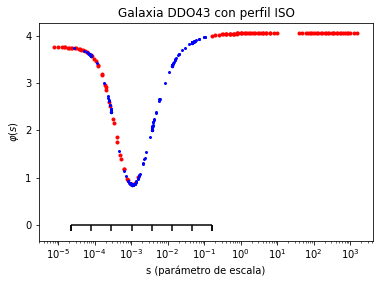

In [16]:
plt.semilogx()
plt.title("Galaxia DDO43 con perfil ISO")
plt.xlabel("s (parámetro de escala)")
plt.ylabel(r"$\varphi(s)$")
plt.scatter(intervalinf, 0, c='black', marker=3)
plt.scatter(intervalsup, 0, c='black', marker=3)
plt.hlines(0, intervalinf, intervalsup)
plt.scatter(Xi, Yi, c='r', marker='.')
plt.scatter(X, np.zeros(len(X)), color='black', marker=3)
plt.scatter(Xj, Yj, c='b', marker='.', linewidths=0.01)
plt.show()

### `redMethRotCurveFitting.py`
Aquí es donde se realiza todo el proceso de ajuste de curvas de rotación, acudiendo a las funciones mencionadas anteriormente. Consta de tres partes: cálculo de límites, reducción del intervalo de búsqueda y minimización de la función varphi. A continuación, incluimos una galaxia más en nuestro conjunto de galaxias y repetimos el proceso desarrollado anteriormente para los perfiles ISO, BUR y NFW, a modo de ejemplo.

In [10]:
import data as dt

galaxlist = ["DDO43", "DDO46"]

fp = open("galaxies/DDO46.arff")
dat, metadt = arff.loadarff(fp)
data = []
for d in dat.tolist():
    data.append(np.asarray(d))
data = np.asarray(data)
galaxies["DDO46"] = {
    "R": data[:, 0] * 1000,
    "vrot": abs(data[:, 1]),
    "errs": data[:, 3],
    "vbary": np.sqrt(data[:, 4] ** 2 + data[:, 5] ** 2)
}
fp.close()

radii = galaxies["DDO46"]["R"]
galaxdata["radii"] = radii
vrot = galaxies["DDO46"]["vrot"]
galaxdata["vrot"] = vrot
vbary = galaxies["DDO46"]["vbary"]
galaxdata["vbary"] = vbary
n = len(radii)
vones = np.ones(n)
galaxdata["vones"] = vones
weights = 1 / ((n - dt.nu) * galaxies["DDO46"]["errs"] ** 2)
galaxdata["weights"] = weights
totalnullvbary = np.sum(vbary) == 0
galaxdata["totalnullvbary"] = totalnullvbary
somenullvbary = round(np.prod(vbary)) == 0
galaxdata["somenullvbary"] = somenullvbary
vv = cf.vv(galaxdata)
galaxdata["vv"] = vv
vvbary = cf.vvbary(galaxdata)
galaxdata["vvbary"] = vvbary

profiles = ["ISO", "BUR", "NFW"]
for g in galaxies:
    print("\n")
    print("GALAXIA ", g)
    for p in profiles:
        galaxdata["profile"] = p
        print("Para el perfil ", p)
        """
        Cálculo de límites
        """
        limits = calLimits(galaxdata)
        varphiLim0 = limits[0]
        varphiLimInf = limits[1]
        print("El límite de varphi cuando s tiende a cero es ", varphiLim0)
        print("El límite de varphi cuando s tiende a infinito es ", varphiLimInf)
        """
        Minimización del intervalo de búsqueda
        """
        interval = intervalMin(varphiLim0, varphiLimInf, galaxdata)
        intervalinf = interval[0][0]
        intervalsup = interval[0][1]
        print("El intervalo de búsqueda deducido es [", intervalinf, ", ", intervalsup, "]")
        intinfmin = interval[1]
        intsupmin = interval[2]
        print("Mínimo encontrado en la exploración del intervalo inferior: ", intinfmin)
        print("Mínimo encontrado en la exploración del intervalo superior: ", intsupmin)
        """
        Minimización de la función varphi
        """
        pmin = varphiMin(varphiLim0, varphiLimInf, intinfmin, intsupmin, intervalinf, intervalsup, galaxdata)
        minvarphi = pmin[0]
        minrho = pmin[1]
        minvarphiX = pmin[2]
        intervalinf = pmin[5]
        intervalsup = pmin[6]
        print("Tras la mejora propuesta en. el algoritmo de minimización de varphi, el intervalo de búsqueda es [", intervalinf, ", ", intervalsup, "]")
        print("El intervalo de búsqueda tras aplicar la mejora propuesta en el algoritmo de minimización de varphi es [", intervalinf, ", ", intervalsup, "]")
        print("El valor mínimo de varphi encontrado es ", minvarphi, ", para s = ", minvarphiX)
        print("El valor de rho(", minvarphiX, ") = ", minrho)



GALAXIA  DDO43
Para el perfil  ISO
El límite de varphi cuando s tiende a cero es  63.01870724925527
El límite de varphi cuando s tiende a infinito es  18.34822521657395
El intervalo de búsqueda deducido es [ 4.3536416896215234e-05 ,  0.6826227918952362 ]
Mínimo encontrado en la exploración del intervalo inferior:  [0.001584893192461114, 15.578755813934777]
Mínimo encontrado en la exploración del intervalo superior:  [0.23341556550007111, 18.005477645569783]
Tras la mejora propuesta en. el algoritmo de minimización de varphi, el intervalo de búsqueda es [ 4.3536416896215234e-05 ,  0.6826227918952362 ]
El intervalo de búsqueda tras aplicar la mejora propuesta en el algoritmo de minimización de varphi es [ 4.3536416896215234e-05 ,  0.6826227918952362 ]
El valor mínimo de varphi encontrado es  [10.14738338] , para s =  0.00396653037336407
El valor de rho( 0.00396653037336407 ) =  [1.30724717]
Para el perfil  BUR
El límite de varphi cuando s tiende a cero es  63.01870724925527
El límite d